# Analise de Fundos de Investimentos

O Portal Brasil - https://www.portalbrasil.net/ tem o ponto de acesso para os principais indicadores financeiros do Brasil.

## Indices comparativos de performace



### CDI

O **Certificado de Depósito Interbancário** são títulos emitidos por instituições financeiras, negociados apenas entre os bancos, que regulam empréstimos de curtíssimo prazo (geralmente um dia) entre os bancos. O CDI tem a finalidade de regular o fluxo de caixa nas instituiçõe bancárias e serve como referência de juros, avaliação de investimentos, além de expressar a expectativa das instituições financeiras frente ao mercado. A série histórica do índice é calculada pela CTIP que é uma empresa particular responsável pela integração do mercado financeiro e faz parte da B3.

Os dados do CDI podem ser acessados através a partir do site da [CETIP][1], da [API][2] do portal de dado abertos Banco Central do Brasil ou do [sistema gestor de séries][3] do BCB. Contudo existe uma difença entre as informações providas entre a CETIP e o Banco Central.

Para as séries extraídas da CETIP temos como indicador o **Fator Diário** que é nesse caso é um número decimal que representa o rendimento anual do CDI, já no BC esse valor é percentual.



### SELIC

### Poupança

### IBOV

### IPCA

### IPCA+6

### Dolar

As infomrações da contação oficial do Dollar pode ser obitida através da API do portal de dados abertos do Banco Central através na URL <https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/swagger-ui3#/>.

### Ouro

### S&P 500

### IFIX

[1]: http://estatisticas.cetip.com.br/astec/series_v05/paginas/lum_web_v05_template_informacoes_di.asp?str_Modulo=completo&int_Idioma=1&int_Titulo=6&int_NivelBD=2
[2]: https://dadosabertos.bcb.gov.br/
[3]: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries


## Code Session

### Bibliotecas requeridas

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math

### Pontos de análise de interesse.

#### Governos da Nova República

In [2]:
JOSE_SARNEY       = ('1985-03-15','1990-03-15')
FERNANDO_COLLOR   = ('1990-03-15','1992-12-29')
ITAMAR_FRANCO     = ('1992-12-29','1995-01-01')
FERNANDO_HENRIQUE = ('1995-01-01','2003-01-01')
LULA              = ('2003-01-01','2011-01-01')
DILMA             = ('2011-01-01','2016-08-31')
TEMER             = ('2016-08-31','2019-01-01')
BOLSONARO         = ('2019-01-01','2023-01-01')

#### Períodos Eleitorais Federal e Estadual.

In [3]:
# Fernando Herique Cardoso - Primeiro Mandato
ELEICAO_1994_T1 = ('1994-10-03')
ELEICAO_1994_T2 = ('1994-11-15')

# Fernando Herique Cardoso - Segundo Mandato
ELEICAO_1998_T1 = ('1998-10-04')
ELEICAO_1998_T2 = ('1998-11-25')

# Lula - Primeiro Mandato
ELEICAO_2002_T1 = ('2002-10-06')
ELEICAO_2002_T2 = ('2002-10-27')

# Lula - Segundo Mandato
ELEICAO_2006_T1 = ('2006-10-01')
ELEICAO_2006_T2 = ('2006-10-29')

# Dilma - Primeiro Mandato
ELEICAO_2010_T1 = ('2010-10-01')
ELEICAO_2010_T2 = ('2010-10-29')

# Dilma - Segundo Mandato
ELEICAO_2014_T1 = ('2014-10-05')
ELEICAO_2014_T2 = ('2014-10-26')

# Bolsonaro - Primeiro Mandato
ELEICAO_2018_T1 = ('2018-10-07')
ELEICAO_2018_T2 = ('2018-10-28')

#### Crises Econômicas Mundiais

### Cógido para acesso ao sistema gerenciador de séries do Banco Central.

In [4]:
# Código das séries históricas no SGS do BC.
SGS_SELIC = 11
SGS_CDI   = 12
SGS_IPCA  = 433 

In [5]:
# Recupera dados de série histórica do banco central, atrávés do código da série.
def get_sgs_data(serie):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(serie)
  df = pd.read_json(url)
  return df

In [6]:
# Recupera os dados de cadastro dos fundo de investimento da CVM
def get_cvm_fi_data():
  url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'
  return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

In [7]:
def get_cvm_fi_info(dt_inicio, dt_fim):
  datas = pd.date_range(dt_inicio, dt_fim, freq='MS') 
  fi_info = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.csv'.format(data.year, data.month)
      fi_info_month = pd.read_csv(url, sep=';')    
    
    except: 
      print("File {} not found".format(url))    

    fi_info = pd.concat([fi_info, fi_info_month], ignore_index=True)

  return fi_info

In [8]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0]
  return fundo

In [9]:
# Recupera a série histórica do CDI.

dt_inicio = '2022-02-01'
dt_fim    = '2022-02-28'

# Plano Verão
# dt_inicio = '1988-11-01'
# dt_fim    = '1989-02-28'

# Presidentes
# dt_inicio, dt_fim = BOLSONARO

df_cdi = get_sgs_data(SGS_CDI) # Retorna a taxa diária de juros do CDI em pontos percentuais 
df_cdi['data'] = pd.to_datetime(df_cdi['data'], dayfirst= True)
df_cdi.set_index('data', inplace= True)
df_cdi = df_cdi.loc[dt_inicio : dt_fim]
df_cdi_acumulado = ((1 + df_cdi/100).cumprod() - 1) * 100

In [10]:
df_cdi

,valor
data,
2022-02-01,0.034749
2022-02-02,0.034749
2022-02-03,0.040168
2022-02-04,0.040168
2022-02-07,0.040168
2022-02-08,0.040168
2022-02-09,0.040168
2022-02-10,0.040168
2022-02-11,0.040168


In [11]:
df_selic = get_sgs_data(SGS_SELIC)
df_selic['data'] = pd.to_datetime(df_selic['data'], dayfirst= True)
df_selic.set_index('data', inplace= True)
df_selic = df_selic.loc[dt_inicio : dt_fim]
df_selic

,valor
data,
2022-02-01,0.034749
2022-02-02,0.034749
2022-02-03,0.040168
2022-02-04,0.040168
2022-02-07,0.040168
2022-02-08,0.040168
2022-02-09,0.040168
2022-02-10,0.040168
2022-02-11,0.040168


In [12]:
df_selic.mean()

valor    0.039598
dtype: float64

In [13]:
df_selic.resample("M").mean()

,valor
data,
2022-02-28,0.039598


O CDI tem como base a SELIC então é normal que ambos sigam com o mesmo valor. Mas diferença entre elas podem ocorrer quando 

Text(0.5, 1.0, 'SELIC')

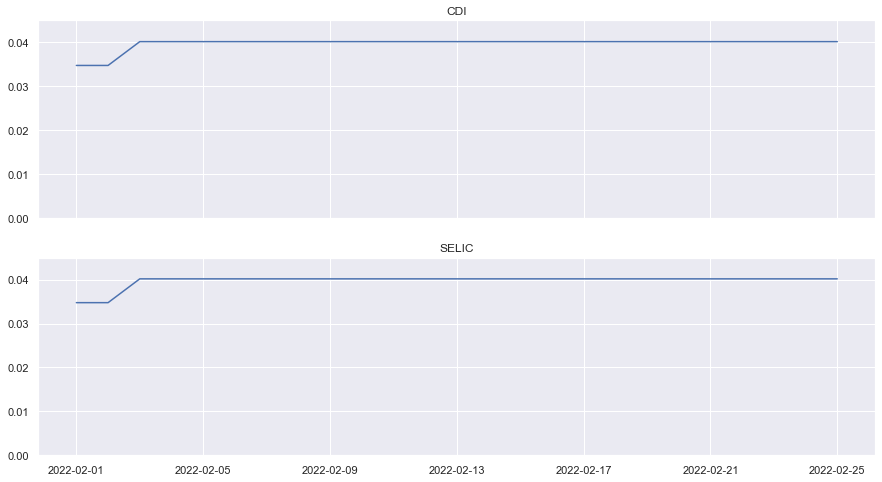

In [14]:
#Traça os gráficos comparativos entre o CDI e a SELIC
fig, ax = plt.subplots(2, 1, sharex= True, figsize= (15,8))
ax[0].plot(df_cdi['valor'])
y0_low, y0_high = ax[0].get_ybound()
ax[0].set_ylim(bottom= 0, top= round(y0_high,2)+0.005)
#ax[0].set_ylim(bottom= 0, top= 2.5)
ax[0].set_title('CDI')

ax[1].plot(df_selic)
y1_low, y1_high = ax[1].get_ybound()
ax[1].set_ylim(bottom= 0, top= round(y1_high,2)+0.005)
#ax[1].set_ylim(bottom= 0, top= 2.5)
ax[1].set_title("SELIC")

In [15]:
# Recupera o IPCA do sistema gestor de séries do BCB.
df_ipca = get_sgs_data(SGS_IPCA)
df_ipca['data'] = pd.to_datetime(df_ipca['data'], dayfirst= True)
df_ipca.set_index('data', inplace= True)
df_ipca = df_ipca.loc['2022-01-01' : '2022-04-27']
#df_ipca = df_ipca.loc[dt_inicio : dt_fim]
df_ipca

,valor
data,
2022-01-01,0.54
2022-02-01,1.01
2022-03-01,1.62


<AxesSubplot:xlabel='data'>

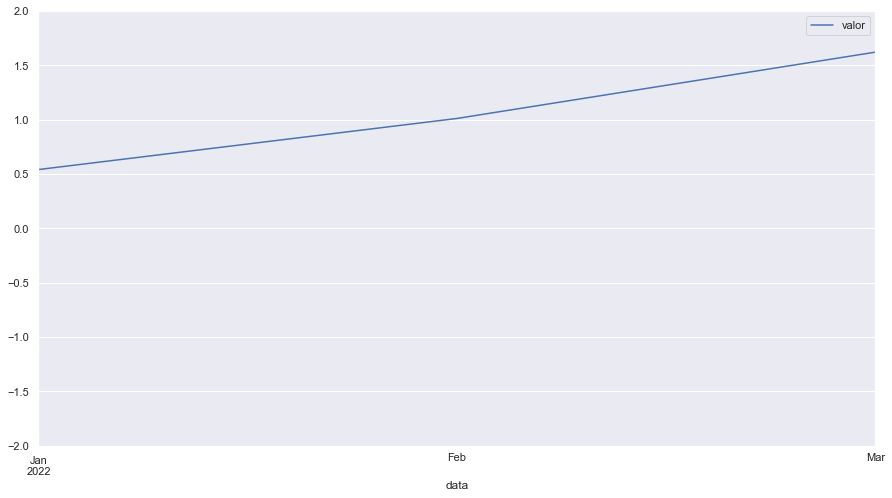

In [16]:
#Traça o gráfico do IPCA 
df_ipca.plot(figsize=(15,8), ylim=(-2,2))

Dados sobre os fundos de invertimento.

In [17]:
#Recupera os dados de cadastro dos fundos de investimento da CVM
fundos_cvm = get_cvm_fi_data()
fundos_cvm

C:\Users\Alexandre Fukaya\AppData\Local\Temp\ipykernel_22556\3108391445.py:4: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url, sep=';', encoding='ISO-8859-1')


,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCE...,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INV...,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC ...,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIME...,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67375,FUNCINE,28.849.405/0001-18,BTG PACTUAL INVESTIMAGE 1 - FUNDO DE FINANCIAM...,2017-10-16,2017-10-09,417002.0,NaN,EM FUNCIONAMENTO NORMAL,2017-12-27,2017-12-27,...,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,30.306.294/0001-45,BANCO BTG PACTUAL S/A,NaN,NaN
67376,FUNCINE,28.850.140/0001-78,FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGR...,2017-10-16,2017-10-06,417001.0,NaN,EM FUNCIONAMENTO NORMAL,2017-12-26,2017-12-26,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS ...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS ...,NaN,NaN
67377,FUNCINE,28.912.043/0001-62,HAPVIDA - FUNDO DE FINANCIAMENTO DA INDUSTRIA ...,2017-10-27,2017-10-19,417003.0,NaN,EM FUNCIONAMENTO NORMAL,2018-12-21,2018-12-21,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS ...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS ...,NaN,NaN
67378,FUNCINE,31.674.280/0001-47,BTG PACTUAL INVESTIMAGE III - FUNDO DE FINANCI...,2018-10-26,2018-09-13,418001.0,NaN,FASE PRÉ-OPERACIONAL,2018-10-26,2018-10-26,...,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.562.112/0001-20,PRICEWATERHOUSECOOPERS AUDITORES INDEPENDENTES...,30.306.294/0001-45,BANCO BTG PACTUAL S/A,NaN,NaN


Os códigos a seguir são para acesso direto aos indicadores.

In [18]:
import requests

In [19]:
# Recupera a Taxa DI com acesso direto a base da CETIP.

url = 'http://estatisticas.cetip.com.br/astec/series_v05/paginas/lum_web_v04_10_03_consulta.asp'

req_headers = {
    'Host'                      : 'estatisticas.cetip.com.br',
    'User-Agent'                : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0',
    'Accept'                    : 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Accept-Language'           : 'en-US,en;q=0.5',
    'Accept-Encoding'           : 'gzip, deflate',
    'Content-Type'              : 'application/x-www-form-urlencoded',
    'Origin'                    : 'http://estatisticas.cetip.com.br',
    'DNT'                       : '1',
    'Referer'                   : 'http://estatisticas.cetip.com.br/astec/series_v05/paginas/lum_web_v04_10_02_gerador_sql.asp',
    'Upgrade-Insecure-Requests' : '1',
    'Sec-GPC'                   : '1'
}

parameters = {
    'str_NomeArquivo'                 : 'WEB_00_DI_Taxas_Over',
    'str_NomeTabela'                  : 'WEB_DI_Taxas_Over',
    'str_Ativo'                       : 'DI',
    'str_ModeloDados'                 : 'TAX_001di',
    'str_Descricao'                   : 'TTTTTT',
    'str_NrLeilao'                    : '_Geral',
    'str_ModeloLeilao'                : '_Geral',
    'str_Descricao_1'                 : '',
    'str_Descricao_2'                 : '',
    'str_Descricao_3'                 : '',
    'chk_Descricao_1'                 : '',
    'chk_Descricao_2'                 : '',
    'chk_Descricao_3'                 : '',
    'bln_MostrarContraparte'          : 'False',
    'str_Populacao'                   : '_Geral',
    'str_FaixaPrazo'                  : '_Geral',
    'str_FaixaPrazoTotalizado'        : '0',
    'str_TipoFaixaPrazo'              : '0',
    'str_TipoEmissao'                 : '0',
    'str_Emissao'                     : '_Geral',
    'str_TipoMoeda'                   : '',
    'str_Moeda'                       : '',
    'str_Observacao'                  : '!DI-CETIP (over)||Observações a respeito de mudança de moeda / volume:|(1) Anos 1986, 1987 e 1988, volume em Cz$ milhões (Cruzado).|(2) A partir de 16/01/1989, corte de três zeros no Cruzado, passando a Cruzado Novo. Volume em NCz$ milhões.|(3) A partir de 15/03/1990, restabelecido o Cruzeiro (Cr$) como moeda nacional. Volume em Cr$ milhões.|(4) A partir de 01/04/1992, em virtude do crescente volume, o mesmo passa a ser divulgado em Cr$ bilhões.|(5) Instituído em 02/08/1993, o Cruzeiro Real (CR$) , com corte de três zeros do Cruzeiro; volume em CR$ milhões.|(6) A partir de 01/11/1993, em virtude do crescimento do volume, o mesmo passa a ser divulgado em CR$ bilhões.|(7) Em Julho/1994, com a implantação do Plano Real, com divisão de valores financeiros por 2.750,00 passando o volume financeiro a ser registrado em milhares de Reais.|           |Observações a respeito da formulação da taxa:|(a) Até 30/06/1989, as taxas dos dias que precediam a fins de semana e feriados eram divididas pelo número de dias destes, de forma a mostrar a taxa over paga pelos dias não úteis.|(b) Até 31/05/1990, taxas divulgadas ao ano de 360 dias, com expressão linear.| Entre 01/06/1990 e 31/12/1997, somente taxas diárias expressas linear ao mês.|(c) A partir de 01/01/1998, taxas médias diárias de DI-Over e de SELIC divulgadas ao ano de 252 dias úteis, com expressão exponencial.|     |Observações a respeito da amostra / base de cálculo da taxa:|(I) Até 29/04/1988, somente taxas envolvendo todas as operações de DI Over.|(II) De 02/05/1988 a 31/05/1990, divisão em Extra-Grupo, Intra-Grupo e Total, sendo o acumulado mensal apenas do Extra-Grupo.|(III) A partir de 01/06/1990, somente taxas do Extra-Grupo.|(IV) A partir de 02/01/1991, inclusão de taxas mínimas, máximas e modais, além do desvio padrão.|     |Observações localizadas:|(i) De acordo com a lei nº 7.320 de 11/06/1985, revogada posteriormente pela lei nº 8.087 de 29/10/1990, foram comemorados por antecipação, nas segundas-feiras, os feriados que caíram nos demais dias da semana, com exceção dos que ocorreram nos sábados e domingos e os dos dias 1º de janeiro (Confraternização Universal), 7 de setembro (Dia da Independência), 25 de dezembro (Natal) e Sexta-Feira Santa.|Com base no exposto, durante o período citado pode ocorrer  a inexistência de taxa para dias considerados como úteis (caso de segundas-feiras imediatamente anteriores a feriados, para onde os mesmos foram deslocados) assim como a existência de taxa para dias considerados como não úteis (caso dos feriados ocorridos entre segunda e sexta-feira, com exceção dos casos já citados).|(ii) Em 23/12/1987, houve também operações diretamente para o dia 28, com cinco dias e um over (saque), com taxa média de 57,66% a.a.|Em 30/12/1987, houve também operações diretamente para o dia 04/01/1988, com cinco dias e dois over (saques), com taxa média de 94,91 % a.a., referentes aos dias 30 e 31/12/1987, abandonando-se, neste caso, a taxa média do dia 31 (60,08 % a.a.).|(iii) Em 12/02/1988, houve também operações diretamente para o dia 18, com seis dias e dois over (saques), com taxa média de 115,72 % a.a.| ||( - ) Dados Insuficientes.',
    'str_NomeAtivoCabecalho'          : 'DI - Depósito Interfinanceiro',
    'str_NomeTipoInformacaoCabecalho' : 'Taxas - DI PRÉ - Over',
    'str_TipoDescricao'               : '5',
    'str_ApresentarTipoOp'            : '0',
    'dta_DataInicio'                  : '01/02/2022',
    'dta_DataFinal'                   : '28/02/2022',
    'str_SQL'                         : 'joao Fdta_DataDivulg, Fdpl_NumOp, Fdpl_Volume, Fsmp_Media, Fsmp_FatorDiario, Fsmp_Minima, Fsmp_Maxima, Fsmp_Moda, Fsmp_DsvPdr, Fsmp_SELIC maria WEB_DI_Taxas_Over Where ( Fdta_DataDivulg >= #02/01/2022# AND Fdta_DataDivulg <= #02/28/2022# ) ORDER BY Fdta_DataDivulg',
    'int_Idioma'                      : '1'
}


cookies = {
    'ASPSESSIONIDCSQRRCAT' : 'GHOGEBCAJDLJDIIFBPJEEPIC',
    'TS01871345' : '01ee5ef46844a27d65554ea6b86003bd46bb7af09e250bf052bf7dc95270e60e93ef143cec76e579ea145d527666e2faba3cc50b73'
}

resp = requests.post(url, data=parameters, headers=req_headers)

In [20]:
resp.text

'<html>\r\n<head>\r\n\t<!-- INCLUDE VIRTUAL = "site2012/astec/Biblioteca/web_v04_99_01_FuncoesBasicas.asp" -->   <!--\'Para o site de produção --> \r\n\t            <!--\'Para o site de homologação --> \r\n\r\n\t\r\n\r\n\t<title>Taxas - DI PRÃ\x89 - Over - DI - DepÃ³sito Interfinanceiro</title>\r\n\r\n\t<script type="text/javascript">\r\n\t\tfunction Fun_Paginacao(str_Direcao){\r\n\tdocument.frm_dados.str_DirecaoMovimento.value = str_Direcao;\r\n\tdocument.frm_dados.submit();\r\n}\r\n\r\n\t</script>\r\n\r\n\t<link rel="stylesheet" href="../../siteb3/styles/foundation.css" />\r\n\t<link rel="stylesheet" href="../../siteb3/styles/jquery.ui.datepicker.css" />\r\n\t<script src="../../siteb3/scripts/vendor/modernizr.js" type="text/javascript"></script>\r\n    <link href="https://fonts.googleapis.com/css?family=Montserrat" rel="stylesheet" />\r\n\r\n</head>\r\n<body>\r\n<div id="divContainerIframeBmf">\r\n\r\n\t\r\n\r\n    <div class="row">\r\n        <div class="large-12 columns">\r\n\t\t\t

In [21]:
## Recupera a cotação do dolar para um determinado período de tempo.

url = "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?%40dataInicial='03-01-2022'&%40dataFinalCotacao='03-31-2022'&%24format=text%2Fcsv"

req_headers = {
    "accept" : "application/json;odata.metadata=minimal"
}

resp = requests.post(url, headers= req_headers)
